In [260]:
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import numpy as np 
import time
import statistics 
import plotly
import plotly.express as px
import plotly.graph_objects as go
from ConvertCurrentToCumulative import hasCumulativeHospitalizations, getCumulativeHospitalizations
from utils import moving_average 
import logging
logging.getLogger().setLevel(logging.CRITICAL)

plt.style.use('ggplot')

alpha = 1
lag_time = 14
doubling_time_window=7

states_dict = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
path = "C:\\Users\\Ron\\StanfordCoronavirusResearch"
colors = ['red', 'orangered', 'yellow', 'gold', 'lime', 'green', 'cyan', 'deepskyblue', 'blue', 'violet', 'purple', 'indigo', 'gray', 'black', 'peru']


reopening_df = pd.read_excel(os.path.join(path, "RawData", "StateReopening", "FinalData.xlsx"))
reopening_df = reopening_df.drop(reopening_df.columns[15:], axis=1)

headers = list(reopening_df.columns)

reopening_effects = [[] for i in range(len(headers) - 1)]
added_hospitalizations = [[] for i in range(len(headers) - 1)]
state_increases = dict()
state_increases_percent = dict() 
state_doubling_times = dict()
state_pre_reopenings = dict()
state_post_reopenings = dict()

def doubling_time(m, y, window):
    y1, y2 = y[m - window], y[m]

    if y1 == 0:
        return 0
    
    return (window) * np.log(2) / np.log(y2 / y1)

def clean_reopening_dates(reopening_dates):
    for i, date in enumerate(reopening_dates):
        if isinstance(date, str):
            date = date.split(" ")[0]
            date = '2020' + '0' * (4 - len(date)) + date
            reopening_dates[i] = int(date)
        elif not math.isnan(date):
            date = str(int(date))
            date = '2020' + '0' * (4 - len(date)) + date
            reopening_dates[i] = int(date)
        else:
            reopening_dates[i] = None
    return reopening_dates

def clean_hospitalizations(hospitalized, dates, state_df):
    index = 0
    for i in range(len(hospitalized)):
        if math.isnan(hospitalized[i]):
            index += 1
        else:
            break

    dates = dates[index:]
    hospitalized = hospitalized[index:]

    for i in range(1, len(hospitalized)):
        if math.isnan(hospitalized[i]):
            hospitalized[i] = hospitalized[i-1]

    calculated = False
    window = 21
#     problem_states = ["Alabama", "Arizona", "Alaska", "Connecticut", "Delaware", 
#                    "Indiana", "Iowa", "Missouri", "New Hampshire", "Pennsylvania",
#                    "Vermont", "West Virginia", ""]
    problem_states = ["Arizona", "Pennsylvania"]
    if len(hospitalized) < window or state in problem_states:
        current_hospitalizations = list(state_df['hospitalizedCurrently'])[::-1]
        dates = list(state_df['date'])[::-1]

        dates = [dates[i] for i in range(len(dates)) if not math.isnan(current_hospitalizations[i])]
        current_hospitalizations = [i for i in current_hospitalizations if not math.isnan(i)]
        
        for i in range(1, len(current_hospitalizations)):
            if math.isnan(current_hospitalizations[i]):
                current_hospitalizations[i] = current_hospitalizations[i-1]

        if len(current_hospitalizations) > window:
            hospitalized = getCumulativeHospitalizations(current_hospitalizations, window)
            calculated = True

    hospitalized = moving_average(hospitalized)
    return hospitalized, dates, calculated

def get_doubling_time_data(hospitalized, doubling_time_window=7, moving_average_window=7):
    doubling_times = [0] * doubling_time_window + [doubling_time(x, hospitalized, doubling_time_window) for x in range(doubling_time_window, len(hospitalized))]
    for i in range(1, len(doubling_times)):
        if math.isinf(doubling_times[i]):
            doubling_times[i] = doubling_times[i-1]
    
    doubling_times_moving_average = [0] * moving_average_window + [np.mean(doubling_times[x - moving_average_window: x]) for x in range(moving_average_window, len(doubling_times))]
    doubling_times_derivative = [0] + [doubling_times_moving_average[i] - doubling_times_moving_average[i-1] for i in range(1, len(doubling_times_moving_average))]
    return doubling_times, doubling_times_moving_average, doubling_times_derivative

def get_xticks(dates):
    x_ticks, x_tick_labels = [], []
    for i in range(0, len(dates), len(dates)//7 - 1):
        date = str(dates[i])
        x_ticks.append(i)
        x_tick_labels.append(date[4:6] + "/" + date[6:8])
    return x_ticks, x_tick_labels

def update_reopening_effects(reoepning_effects, reopening_indecies, doubling_times_derivative, lag_time=14):
    state_pre_reopenings[state] = []
    state_post_reopenings[state] = []
    for num, index in enumerate(reopening_indecies):
        if index is not None and num + lag_time*2 < len(doubling_times_derivative):
            pre = np.mean(doubling_times_derivative[index:index + lag_time])
            post = np.mean(doubling_times_derivative[index + lag_time:index + lag_time*2])
            if not math.isnan(pre) and not math.isnan(post) and not math.isnan((post - pre / pre)*100):
                reopening_effects[num].append((post - pre / pre)*100)              
    return reopening_effects

def plot_reopenings(reopening_indecies, spike_expectations, names, colors=colors, alpha=1, include_spike_expectations=True):
    for num, index in enumerate(reopening_indecies):
        if index is not None:
            plt.axvline(x=index, linestyle='solid', label=names[num] + " Reopening", color=colors[num], alpha=alpha)
    for num, index in enumerate(spike_expectations):
        if index is not None and include_spike_expectations:
            plt.axvline(x=index, linestyle='dotted', color=colors[num], alpha=alpha)

def update_plot(title, ylabel, reopening_indecies, spike_expectations, x_ticks, x_tick_labels, calculated, names, include_spike_expectations=True, add_reopenings=True):
    if add_reopenings:
        plot_reopenings(reopening_indecies, spike_expectations, names, include_spike_expectations=include_spike_expectations)
    plt.xticks(x_ticks, x_tick_labels)
    plt.xlabel("Dates")
    if ylabel == 0:
        plt.ylabel("Cumulative COVID-19 Hospitalizations")
    elif ylabel == 1:
        plt.ylabel("COVID-19 Hospitalization Doubling Time (Days)")
    else:
        plt.ylabel(ylabel)
    if calculated:
        title += " (Calc)"
    plt.title(title)

    

In [261]:
for state in states_dict:
    print(state)
    save_folder = os.path.join(path, "Graphs", "Analysis", state)
    if not os.path.isdir(save_folder):
        os.mkdir(save_folder)
    
    state_df = pd.read_csv(os.path.join(path, "RawData", state, f"{states_dict[state].lower()}_covid_track_api_data.csv"))
    hospitalized = list(state_df['hospitalizedCumulative'])[::-1]
    dates = list(state_df['date'])[::-1]

    reopening_dates = []
    for i, row in reopening_df.iterrows():
        if list(row)[0] == state:
            reopening_dates = list(row)[1:]

    reopening_dates = clean_reopening_dates(reopening_dates)
    hospitalized, dates, calculated = clean_hospitalizations(hospitalized, dates, state_df)
    doubling_times, doubling_times_moving_average, doubling_times_derivative = get_doubling_time_data(hospitalized, doubling_time_window)
    x_ticks, x_tick_labels = get_xticks(dates)

    names, reopening_dates = headers[1:], reopening_dates
    reopening_indecies = [dates.index(i) if i is not None and i in dates else None for i in reopening_dates]
    spike_expectations = [min(i + lag_time, len(hospitalized)) if i is not None else None for i in reopening_indecies]

    reopening_effects = update_reopening_effects(reopening_effects, reopening_indecies, doubling_times_derivative, lag_time=lag_time)
    
    state_pre_reopenings[state] = []
    state_post_reopenings[state] = []
    
    for num, index in enumerate(reopening_indecies):
        if index is not None and num + lag_time*2 < len(doubling_times_derivative):
            state_pre_reopenings[state].append(np.mean(doubling_times_derivative[index:index+lag_time]))
            state_post_reopenings[state].append(np.mean(doubling_times_derivative[index+lag_time:index+lag_time*2]))
            
    # print(dates)
    if 20200601 in dates and 20200630 in dates:
        july_start, july_end = dates.index(20200601), dates.index(20200630)
        sublist = doubling_times_moving_average[july_start:july_end]
        state_doubling_times[state] = (sublist[-1] - sublist[0])/len(sublist)# statistics.median(sublist)
        # print(sublist, state_doubling_times[state])
        
    # print(reopening_indecies)
    for i, index in enumerate(reopening_indecies):
        if index is not None and index in reopening_indecies[:i]:
            nums_to_try = [1, -1, 2, -2, 3, -3, 4, -4, 5, -5]
            original_index = index; count = 0
            while index in reopening_indecies[:i]:
                index = original_index + nums_to_try[count]
                count += 1
            reopening_indecies[i] += nums_to_try[count-1]
            spike_expectations[i] += nums_to_try[count-1]
    # print(reopening_indecies)

    exponential_doublings = [[i, doubling_times_moving_average[i + lag_time]] if i is not None and i + lag_time*1.5 < len(doubling_times_derivative) and np.mean(doubling_times_derivative[i + lag_time:min(i + lag_time*2, len(doubling_times_derivative))]) < np.mean(doubling_times_derivative[i:i+lag_time]) else None for i in reopening_indecies]


    plt.plot(hospitalized, color='k', label='Actual Hospitalizations')
    update_plot(f"Reopenings - {state}", 0, reopening_indecies, spike_expectations, x_ticks, x_tick_labels, calculated, names, include_spike_expectations=False)
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    # plt.show()
    plt.savefig(os.path.join(save_folder, "4reopenings.png"), bbox_inches='tight')
    plt.clf()

    plt.plot(hospitalized, color='k', label='Actual Hospitalizations')
    update_plot(f"Reopenings - {state}", 0, reopening_indecies, spike_expectations, x_ticks, x_tick_labels, calculated, names)
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    # plt.show()
    plt.savefig(os.path.join(save_folder, "4reopenings_with_lag_times.png"), bbox_inches='tight')
    plt.clf()

    update_plot(f"Reopenings - {state}", 1, reopening_indecies, spike_expectations, x_ticks, x_tick_labels, calculated, names)
    plt.plot(doubling_times_moving_average, label="Doubling Time (7-Day Moving Average)", color='k')
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    plt.savefig(os.path.join(save_folder, "5doubling_times_reopenings.png"), bbox_inches='tight')
    plt.clf()

    x = [range(i[0], len(hospitalized)) if i is not None else None for i in exponential_doublings]
    y = [[hospitalized[doubling[0]] * (2 ** ((time - doubling[0])/doubling[1])) for time in range(doubling[0], len(hospitalized))] if doubling is not None else None for doubling in exponential_doublings]

    for num, index in enumerate(reopening_indecies):
        if exponential_doublings[num] is not None and y[num][-1] < hospitalized[-1]:
            plt.axvline(x=index, color=colors[num], linestyle='solid', label=names[num] + " Reopening", alpha=alpha)
    for num, index in enumerate(spike_expectations):
        if exponential_doublings[num] is not None and y[num][-1] < hospitalized[-1]:
            plt.axvline(x=index, color=colors[num], linestyle='dotted', alpha=alpha)

    update_plot(f"Reopenings With Negative Effects - {state}", 1, reopening_indecies, spike_expectations, x_ticks, x_tick_labels, calculated, names, add_reopenings=False)
    plt.plot(doubling_times_moving_average, label="Doubling Time (7-Day Moving Average)", color='k')
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    # plt.show()
    plt.savefig(os.path.join(save_folder, "6doubling_times_negative_reopenings.png"), bbox_inches='tight')
    plt.clf()

    for num, index in enumerate(reopening_indecies):
        if exponential_doublings[num] is not None and y[num][-1] < hospitalized[-1]:
            plt.axvline(x=index, linestyle='solid', label=names[num] + " Reopening", color=colors[num], alpha=alpha)
    for num, index in enumerate(spike_expectations):
        if exponential_doublings[num] is not None and y[num][-1] < hospitalized[-1]:
            plt.axvline(x=index, linestyle='dotted', color=colors[num], alpha=alpha)
    plt.plot(hospitalized, color='k', label='Actual Hospitalizations')
    update_plot(f"Reopenings With Negative Effects - {state}", 0, reopening_indecies, spike_expectations, x_ticks, x_tick_labels, calculated, names, add_reopenings=False)
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    # plt.show()
    plt.savefig(os.path.join(save_folder, "7negative_reopenings.png"), bbox_inches='tight')
    plt.clf()

    plt.plot(hospitalized, color="k")
    state_increases[state] = []
    state_increases_percent[state] = []
    for i in range(len(x)):
        if x[i] is not None:
            if y[i][-1] < hospitalized[-1]:
                plt.plot(x[i], y[i], color=colors[i], linestyle="dashed")
                added_hospitalizations[i].append(hospitalized[-1] - y[i][-1])# (hospitalized[-1] - y[i][-1])/y[i][-1])
                state_increases[state].append(hospitalized[-1] - y[i][-1])
                state_increases_percent[state].append((hospitalized[-1] - y[i][-1]) / y[i][-1])
                if exponential_doublings[i] is not None:
                    plt.axvline(x=reopening_indecies[i], linestyle='solid', label=names[i] + " Reopening", color=colors[i], alpha=alpha) 
                    plt.axvline(x=spike_expectations[i], linestyle='dotted', color=colors[i], alpha=alpha)
        else:
            state_pre_reopenings[state].append(None)
            state_post_reopenings[state].append(None)
    state_increases[state] = max(state_increases[state]) if len(state_increases[state]) != 0 else 0
    state_increases_percent[state] = max(state_increases_percent[state]) * 100 if len(state_increases_percent[state]) != 0 else 0

    update_plot(f"Predicted Trajectories Without Reopenings - {state}", 0, reopening_indecies, spike_expectations, x_ticks, x_tick_labels, calculated, names, add_reopenings=False)

    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
    # plt.show()
    plt.savefig(os.path.join(save_folder, "8predictions.png"), bbox_inches='tight')
    plt.clf()

Alabama
Alaska


<ipython-input-260-c89e89dc2eac>:103: RuntimeWarning:

divide by zero encountered in double_scalars

<ipython-input-260-c89e89dc2eac>:183: RuntimeWarning:

invalid value encountered in double_scalars



American Samoa
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia
Florida
Georgia
Guam
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Northern Mariana Islands
Ohio
Oklahoma
Oregon
Pennsylvania
Puerto Rico
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virgin Islands
Virginia
Washington
West Virginia
Wisconsin
Wyoming


<Figure size 432x288 with 0 Axes>

[(201.49960257134407, 'Beaches'), (183.8390155387184, 'Limitted Retail'), (148.0248660533767, 'Restaurants (Outdoors)'), (83.05631380589841, 'Parks'), (78.93874962556065, 'Offices'), (63.26304774739573, 'Construction'), (-6.419095767652323, 'Full Retail'), (-7.3809540674186715, 'Gyms'), (-9.792526281556235, 'Personal Care'), (-14.866283267427232, 'Entertainment'), (-15.764643638772995, 'Hair Salons'), (-23.730002227751378, 'Restaurants'), (-48.31022484062966, 'Houses of Worship'), (-89.58464913712592, 'Restaurants/Bars')]

State Increases: {'Alabama': 6830.728409870916, 'Alaska': 10.047138236530849, 'American Samoa': 0, 'Arizona': 2872.7850031473317, 'Arkansas': 1507.5950274066888, 'California': 6737.328825497589, 'Colorado': 607.2299377504014, 'Connecticut': 0, 'Delaware': 161.6082550586591, 'District of Columbia': 15.20902897903079, 'Florida': 7118.543846876593, 'Georgia': 0, 'Guam': 0, 'Hawaii': 118.00902672894522, 'Idaho': 587.1432928463627, 'Illinois': 1830.0995635826075, 'Indiana

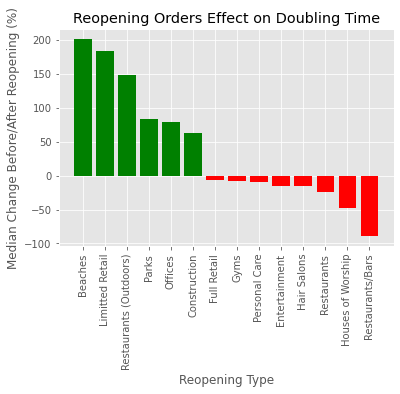

In [262]:
reopening_effects_means = [np.mean(i) for i in reopening_effects]
reopening_effects_medians = [statistics.median(i) if len(i) != 0 else 0 for i in reopening_effects]
# print(reopening_effects_means)
# print(reopening_effects_medians)

for i in [["Median", reopening_effects_medians]]: # ["Mean", reopening_effects_means]]:
    title, data = i
    
    reopenings_with_headers = zip(data, headers[1:])
    reopenings_with_headers = sorted(reopenings_with_headers, key=lambda x: -1*x[0])
    print(reopenings_with_headers)
    # print(reopenings_with_headers)

    negative_reopenings = [x[0] for x in reopenings_with_headers if x[0] < 0]
    positive_reopenings = [x[0] for x in reopenings_with_headers if x[0] >= 0]
    # print(len(negative_reopenings), len(positive_reopenings))
    labels = [x[1] for x in reopenings_with_headers]

    plt.title("Reopening Orders Effect on Doubling Time")
    plt.xlabel("Reopening Type")
    plt.ylabel(f"{title} Change Before/After Reopening (%)")
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.bar(range(len(positive_reopenings)), positive_reopenings, color="g")
    plt.bar(range(len(positive_reopenings), len(positive_reopenings) + len(negative_reopenings)), negative_reopenings, color="r")
    # plt.savefig(os.path.join(path, "Graphs", "Analysis", f"ReopeningData{title}-{lag_time}.png"), bbox_inches='tight')
    # plt.show()

# state_increases = {state: max(state_increases[state]) if len(state_increases[state]) > 0 else 0 for state in state_increases}
print("\nState Increases: ", state_increases, sep="")
print("\nState Increases (Percent): ", state_increases_percent, sep="")
total = sum(state_increases.values())
print("\nTotal: ", total, sep="")
sum_added_hospitalizations = [sum(x) if len(x) > 0 else 0 for x in added_hospitalizations]
print("\nTotal Added Hospitalizations: ", sorted(zip(headers[1:], sum_added_hospitalizations), key = lambda x: -1*x[1]), sep="")
median_added_hospitalizations = [statistics.median(x) if len(x) > 0 else 0 for x in added_hospitalizations]
print("\nMedian Added Hospitalizations: ", sorted(zip(headers[1:], median_added_hospitalizations), key = lambda x: -1*x[1]), sep="")

In [283]:
fig = px.choropleth(locations=[states_dict[state] for state in state_increases_percent], locationmode="USA-states", color=[increase for increase in state_increases_percent.values()], scope="usa")
# fig.show()

# for state in state_doubling_times:
#     if state_increases[state] > 7500:
#         state_increases[state] = 7500
#     if state_increases_percent[state] > 100:
#         state_increases_percent[state] = 100
#     if state_doubling_times[state] > 400:
#         state_doubling_times[state] = 400

new_state_increases = [np.log10(i) if i != 0 else 0 for i in list(state_increases.values())]
new_state_increases_percent = [np.log10(i) if i != 0 else 0 for i in list(state_increases_percent.values())]
new_state_doubling_times = list(state_doubling_times.values())

print(headers)
reopening = "Restaurants (Outdoors)"
index = headers.index(reopening)

new_pre = {state: state_pre_reopenings[state][index] for state in state_increases if len(state_pre_reopenings[state]) > 13}
new_post = {state: state_post_reopenings[state][index] for state in state_increases if len(state_pre_reopenings[state]) > 13}

change = [((new_post[state] - new_pre[state])/new_pre[state])*100 if new_post[state] is not None and new_pre[state] is not None else None for state in state_increases if len(state_pre_reopenings[state]) > 13]

new_pre = [np.log10(i) if i is not None and i > 0 else None if i is None else -1*np.log10(abs(i)) if i < 0 else 0 for i in list(new_pre.values())]
new_post = [np.log10(i) if i is not None and i > 0 else None if i is None else -1*np.log10(abs(i)) if i < 0 else 0 for i in list(new_post.values())]
new_change = [np.log10(i) if i is not None and i > 0 else None if i is None else -1*np.log10(abs(i)) if i < 0 else 0 for i in change]
new_state_doubling_times = [np.log10(i) if i is not None and i > 0 else None if i is None else -1*np.log10(abs(i)) if i < 0 else 0 for i in list(state_doubling_times.values())]

states = [states_dict[state] for state in state_increases if len(state_pre_reopenings[state]) > 13]

# data = list(state_increases.values())
data = [(new_pre, "Pre"), (new_post, "Post"), (new_change, "Difference")]

for d, info in data:
    fig = go.Figure(data=go.Choropleth(
        locations=states, # Spatial coordinates
        z = d, # Data to be color-coded
        zmin = -3,
        zmax = 2,
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = 'Reds',
        colorbar=dict(title="Log-Scale (%)",
        tickvals= [-3, -2, -1, 0, 1, 2, 3, 4],
        ticktext= ['-1000', '-100', '-10', '1', '10', '100', '1000', '10000']),
        reversescale=True,
    ))

    fig.update_layout(
        title_text = f'COVID-19 Doubling Time Rate of Change {info}-{reopening} Reopening',
        geo_scope='usa' # limite map scope to USA
    )

    fig.show()
    
states = [states_dict[state] for state in state_doubling_times]
    
fig = go.Figure(data=go.Choropleth(
    locations=states, # Spatial coordinates
    z = new_state_doubling_times, # Data to be color-coded
    zmin = -2,
    zmax = 2,
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar=dict(title="Log Scale",
    tickvals= [-3, -2, -1, 0, 1, 2, 3, 4],
    ticktext= ['-1000', '-100', '-10', '1', '10', '100', '1000', '10000']),
    reversescale=True,
))

fig.update_layout(
    title_text = f'COVID-19 Doubling Time Rate of Change in June',
    geo_scope='usa' # limite map scope to USA
)

fig.show()

['Unnamed: 0', 'Restaurants (Outdoors)', 'Restaurants/Bars', 'Restaurants', 'Limitted Retail', 'Full Retail', 'Hair Salons', 'Personal Care', 'Gyms', 'Entertainment', 'Houses of Worship', 'Offices', 'Construction', 'Beaches', 'Parks']


<ipython-input-283-25545d23eb42>:23: RuntimeWarning:

invalid value encountered in double_scalars



In [150]:
print(state_doubling_times)

{'Alabama': 51.94639699998675, 'Alaska': 500.0, 'Arizona': 44.20929447539085, 'Arkansas': 31.0929166325799, 'California': 46.24462638467291, 'Colorado': 178.47146244625407, 'Connecticut': 500.0, 'Delaware': 230.98024216953507, 'District of Columbia': 292.87049793226475, 'Florida': 44.343052857981306, 'Georgia': 50.062921989227405, 'Guam': 500.0, 'Hawaii': 52.001455727356706, 'Idaho': 30.947445270114926, 'Illinois': 393.984313200629, 'Indiana': 129.93288027100232, 'Iowa': 500.0, 'Kansas': 61.59491412029527, 'Kentucky': 144.79879749623632, 'Louisiana': 87.37174792849224, 'Maine': 143.0878495226616, 'Maryland': 172.78941299867722, 'Massachusetts': 372.39631919821227, 'Michigan': 545.1685412070126, 'Minnesota': 97.84153696016354, 'Mississippi': 71.25518939689346, 'Missouri': 386.3510303190935, 'Montana': 36.93154473083585, 'Nebraska': 110.92654418841514, 'Nevada': 31.880879116287943, 'New Hampshire': 159.71262883547809, 'New Jersey': 241.70812320279074, 'New Mexico': 63.62749543640321, 'Ne